# Code to classify transaction kadence and amount variability

## Import modules and read data set

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#
dani_data = pd.read_csv('/content/drive/MyDrive/Jovia/statement_dani.CSV')

dani_data.columns = ['transaction_type','transaction_date','transaction_description','transaction_amount']

dani_data.drop('transaction_type', axis=1, inplace=True)

dani_data['transaction_date'] = pd.to_datetime(dani_data['transaction_date'])

cols = ['transaction_date', 'transaction_amount','transaction_description']

dani_data = dani_data[cols]

dani_data['account_holder']='Dani'

<ipython-input-5-d6e659f2fa42>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dani_data['account_holder']='Dani'


### Text processing

In [6]:
pip install fuzzywuzzy

In [7]:
from fuzzywuzzy import fuzz

def assign_names(strings, threshold):
    # Calculate similarity scores between pairs of strings
    # Assign the same name to strings with similarity above the threshold
    for i in range(len(strings)):
        for j in range(len(strings)):
            if fuzz.token_sort_ratio(strings[i], strings[j]) > threshold:
                strings[j] = strings[i]

    return strings



# Assign names based on the threshold
assign_names(dani_data['transaction_description'], 60)



/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
<ipython-input-7-716e25376e9b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strings[j] = strings[i]


0     ORIG CO NAME:IRS  TREAS 310   CO ENTRY DESCR: ...
1     POS DEBIT                                     ...
2     CHERRY VALLEY MA 490 H W HEMPSTEAD NY838388  0...
3                Zelle payment to Allie AU JPM99aa39syv
4     CMSVEND*CV FARMINGDALE AMITYVILLE NY         0...
                            ...                        
89    BAR LA CONDESA CAFERT BOADILLA DEL           0...
90      Zelle payment from ALLISON VAZQUEZ 0P20NBU1UCOW
91                                  MONTHLY SERVICE FEE
92    FOREIGN EXCHANGE RATE ADJUSTMENT FEE         0...
93    DRACO LOUNGE 2022 BOADILLA DEL               0...
Name: transaction_description, Length: 94, dtype: object

In [8]:
def similarity_heat_map(data):
  similarity_matrix = pd.DataFrame([[fuzz.token_sort_ratio(data[i], data[j]) for j in range(len(data))] for i in range(len(data))])
  similarity_matrix[similarity_matrix>50]
  sns.heatmap(similarity_matrix[similarity_matrix>50], annot=True)


## Read Dr. Venkatesh's statement

In [9]:
ven_data = pd.read_excel("/content/drive/MyDrive/Jovia/Sample Ledger.xlsx")
ven_data.columns = ['account_number', 'transaction_date', 'transaction_amount','transaction_type','transaction_description']

In [10]:
ven_data.drop(['transaction_type','account_number'], axis=1, inplace=True)

In [11]:
ven_data['account_holder']='Dr. Venkatesh'

In [12]:
data = ven_data.append(dani_data)

<ipython-input-12-2cdcf756a91b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = ven_data.append(dani_data)


## Create a table to get Coefficient of variance of the

In [13]:
# Group the dataframe by source and get the time difference between the sucesive rows or transactions
data['time_diff'] = data.groupby(['transaction_description','account_holder'])['transaction_date'].diff(periods=-1)

# Drop nas and store data in a new variable
data_for_mean = data.dropna()

In [14]:
# Function that returns kadence = inf if a source happened less than 3 times
def less_count(data):

  if data['count_amount'] < 3:
    return np.inf

  else:
     return data['kadence']

In [15]:
# Group_time_diff by source
grouped_time_diff = data_for_mean.groupby('transaction_description')['time_diff']

# Get mean time difference
mean_time_diff = (grouped_time_diff.apply(lambda x: np.mean(x)))

# get the standard deviation of the time difference
std_time_diff = (grouped_time_diff.apply(lambda x: np.std(x)))

# get the mean transaction amount for a source
mean_amount = data.groupby('transaction_description')['transaction_amount'].mean()

# get the standard deviation of the transaction amount of a source
std_amount = data.groupby('transaction_description')['transaction_amount'].std()

# Get the ampount of times a source happened
count_amount = data.groupby('transaction_description')['transaction_amount'].count()

# Concatenate all the previous variables
data1 = pd.concat([count_amount, mean_time_diff, std_time_diff, mean_amount,std_amount], axis=1)

# Rename them
data1.columns = ['count_amount','mean_time_diff','std_time_diff', 'mean_transaction_amount','std_transaction_amount']

# Define Kadence as the coefficient of variance of the time difference of the occurances of a source
data1['kadence'] = np.abs(data1['std_time_diff']/data1['mean_time_diff'])

# Calculate Coefficient of Variance of the tranaction amounts of a source
data1['trans_amount_var'] = np.abs(data1['std_transaction_amount']/data1['mean_transaction_amount'])

# Applies the function defined above
data1['kadence'] = data1.apply(less_count, axis = 1)

# Transforms kadence to a 0,1 scale from the current 0, inf scale
data1['kadence1'] = data1['kadence']/(data1['kadence']+1)

# Different type of transformation
data1['kadence2'] = (data1['kadence']**2)/(data1['kadence']**2+1)

# Different type of transformation
data1['kadence3'] = (2*np.arctan(data1['kadence']))/np.pi

# Different type of transformation
data1['kadence4'] = 1-np.exp(-data1['kadence'])

# Fill nas with 1
data1['kadence1'].fillna(1, inplace = True)
data1['kadence2'].fillna(1, inplace = True)
data1['kadence3'].fillna(1, inplace = True)
data1['kadence4'].fillna(1, inplace = True)

# Transforms CV of transaction amount as well
data1['trans_amount_var'] = data1['trans_amount_var']/(data1['trans_amount_var']+1)
data1['trans_amount_var'].fillna(1, inplace = True)

# Drops unnecessary columns
kadence_trans_amount = data1.drop(columns = ['kadence', 'mean_transaction_amount', 'std_transaction_amount'])
#kadence_trans_amount = data1.copy()
kadence_trans_amount['transaction'] = kadence_trans_amount.index

In [16]:
kadence_trans_amount.sort_values(by='count_amount', ascending = False)

,count_amount,mean_time_diff,std_time_diff,trans_amount_var,kadence1,kadence2,kadence3,kadence4,transaction
transaction_description,,,,,,,,,
FOREIGN EXCHANGE RATE ADJUSTMENT FEE 01/12TESCO STO,15,1 days 00:00:00,2 days 04:53:36.325830683,0.538163,0.687880,0.829268,0.728824,0.889627,FOREIGN EXCHANGE RATE ADJUSTMENT FEE 0...
Deposit from ADELPHI UNIVERSI PAYROLL,6,15 days 09:36:00,1 days 20:30:48.127602165,0.196978,0.107491,0.014298,0.076305,0.113467,Deposit from ADELPHI UNIVERSI PAYROLL
LITTLE ITALY LONDON 01/11 Pound Sterl15.00 X 1.278000 (EXCHG RTE),6,0 days 04:48:00,0 days 09:36:00,0.404126,0.666667,0.800000,0.704833,0.864665,LITTLE ITALY LONDON 0...
Zelle payment from ALIA FIGUEREDO 19973547020,5,7 days 00:00:00,6 days 06:50:15.579886986,0.419277,0.473086,0.446328,0.465765,0.592553,Zelle payment from ALIA FIGUEREDO 19973547020
Zelle payment to Allie AU JPM99aa39syv,4,9 days 08:00:00,6 days 14:23:30.908348831,0.488860,0.414214,0.333333,0.391827,0.506931,Zelle payment to Allie AU JPM99aa39syv
...,...,...,...,...,...,...,...,...,...
TRADER JOE S #55 TRADE GARDEN CITY NY700789 02/13,1,NaT,NaT,1.000000,1.000000,1.000000,1.000000,1.000000,TRADER JOE S #55 TRADE GARDEN CITY NY700789 0...
ESPN Plus 800-7271800 NY 01/18,1,NaT,NaT,1.000000,1.000000,1.000000,1.000000,1.000000,ESPN Plus 800-7271800 NY 0...
UNCLE BACALA S NEW HYDE PARK NY 02/09,1,NaT,NaT,1.000000,1.000000,1.000000,1.000000,1.000000,UNCLE BACALA S NEW HYDE PARK NY 0...


In [17]:
source_greater_1 = kadence_trans_amount[kadence_trans_amount['count_amount']>=2].index
source_equal_1 = kadence_trans_amount[kadence_trans_amount['count_amount']>=2].index

(-0.03439398403603419,
 0.7222736647567181,
 -0.04146341463414628,
 0.8707317073170718)

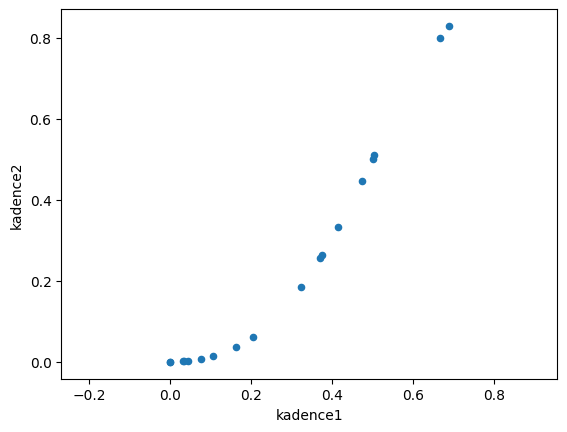

In [18]:
kadence_trans_amount[kadence_trans_amount[['kadence1','kadence2','kadence3']]<1].plot.scatter(x= 'kadence1', y='kadence2')
plt.axis('equal')

(-0.03439398403603419,
 0.7222736647567181,
 -0.03644121104103909,
 0.7652654318618208)

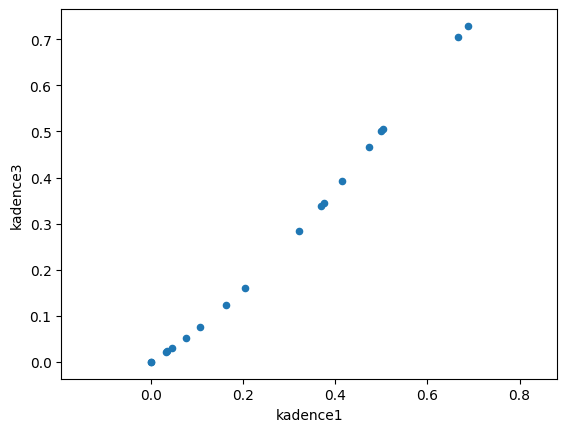

In [19]:
kadence_trans_amount[kadence_trans_amount[['kadence1','kadence2','kadence3']]<1].plot.scatter(x= 'kadence1', y='kadence3')
plt.axis('equal')

(-0.03644121104103909,
 0.7652654318618208,
 -0.04146341463414628,
 0.8707317073170718)

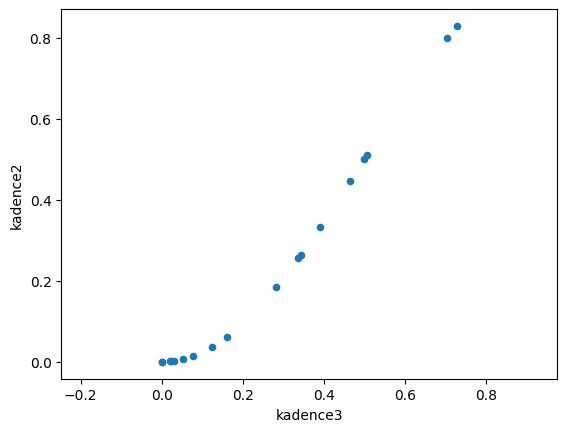

In [20]:
kadence_trans_amount[kadence_trans_amount[['kadence1','kadence2','kadence3']]<1].plot.scatter(x= 'kadence3', y='kadence2')
plt.axis('equal')

<Axes: xlabel='kadence1', ylabel='kadence4'>

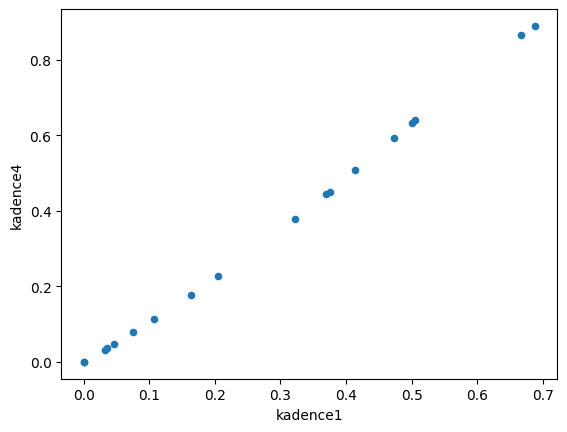

In [21]:
kadence_trans_amount[kadence_trans_amount[['kadence1','kadence4']]<1].plot.scatter(x= 'kadence1', y='kadence4')


<Axes: xlabel='kadence2', ylabel='kadence4'>

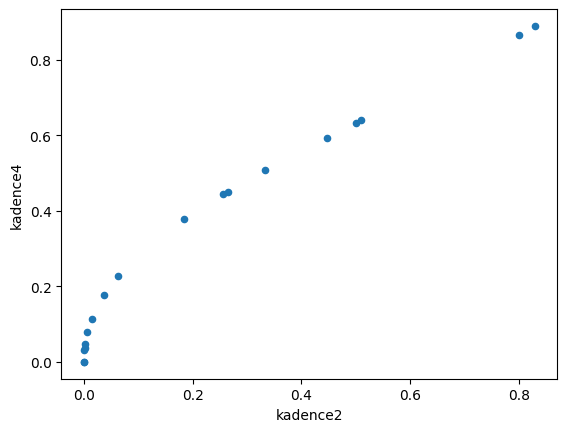

In [22]:
kadence_trans_amount[kadence_trans_amount[['kadence2','kadence4']]<1].plot.scatter(x= 'kadence2', y='kadence4')


<Axes: xlabel='kadence3', ylabel='kadence4'>

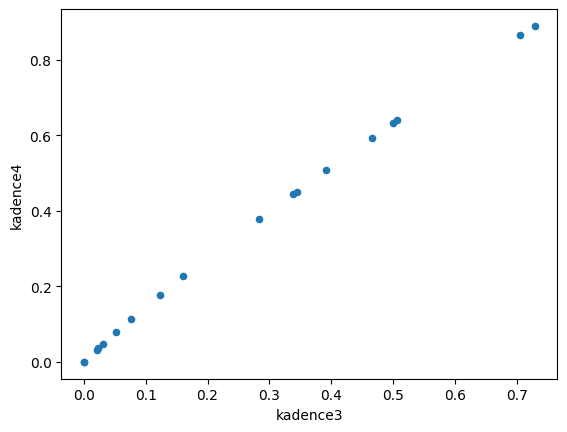

In [23]:
kadence_trans_amount[kadence_trans_amount[['kadence3','kadence4']]<1].plot.scatter(x= 'kadence3', y='kadence4')


In [24]:
data_to_plot =kadence_trans_amount.copy()
data_to_plot.reset_index(inplace=True)


## Plot

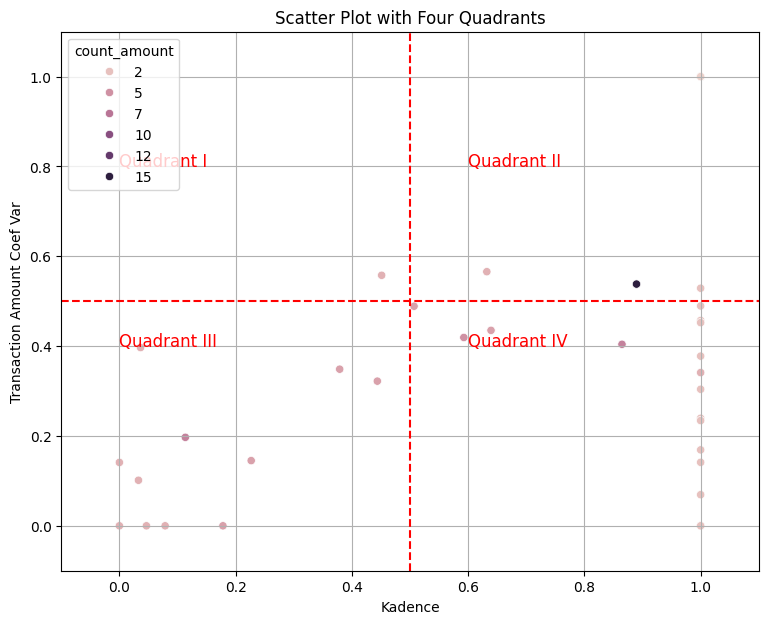

In [25]:
# Define the boundaries for quadrants
x_boundary = 0.5
y_boundary = 0.5

# Create the scatter plot
plt.figure(figsize=(9, 7))

# Plot the points
sns.scatterplot(x="kadence4",y="trans_amount_var",hue = 'count_amount',data=data_to_plot)
# Plot the quadrant boundaries
plt.axvline(x_boundary, color='r', linestyle='--')
plt.axhline(y_boundary, color='r', linestyle='--')

# Add annotations for quadrants
plt.text(0, 0.8, 'Quadrant I', fontsize=12, color='r')
plt.text(0.6, 0.8, 'Quadrant II', fontsize=12, color='r')
plt.text(0, 0.4, 'Quadrant III', fontsize=12, color='r')
plt.text(.6, .4, 'Quadrant IV', fontsize=12, color='r')

'''for i, row in data_to_plot.iterrows():
  plt.text(row['kadence']-.01, row['trans_amount_var']-.03, row['transaction'], fontsize=6, ha='left')
'''
# Set plot limits
plt.xlim(-.1, 1.1)
plt.ylim(-.1, 1.1)

# Add labels and title
plt.xlabel('Kadence')
plt.ylabel('Transaction Amount Coef Var')
plt.title('Scatter Plot with Four Quadrants')

# Show plot
plt.grid(True)
plt.show()





In [26]:
#pip install plotly

In [27]:
import plotly.express as px

# Plotly Scatter Plot
fig = px.scatter(data_to_plot, x='kadence4', y='trans_amount_var', color='count_amount', hover_name='transaction_description',
                 title='Interactive Scatter Plot',
                 labels={'x': 'X-axis', 'y': 'Y-axis', 'category': 'Category'})


# Define the boundaries for quadrants

# Add vertical line at x=0.5 and horizontal line at y=0.5
fig.add_vline(x=0.5, line_dash="dash", line_color="black")
fig.add_hline(y=0.5, line_dash="dash", line_color="black")

# Customize the layout
fig.update_layout(
    title='Plot Kadence vs. Amount Variability for Transactions', # Title
    xaxis_title='Kadence', # x-axis name
    yaxis_title='Transaction Amount Variability', # y-axis name
    width=800,  # Set the width of the figure to 800 pixels
    height=600  # Set the height of the figure to 600 pixels
)
# Show the plot
fig.show()


# Autocorrelation implementation // Old

### Try with one_hot_encoding

In [28]:
data['week']=data['transaction_date'].dt.week

<ipython-input-28-2ab94c28d7ec>:1: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [29]:
one_hot_week = pd.get_dummies(data,columns=['week']).drop(columns=['time_diff','transaction_amount'])

In [30]:
one_hot_week

,transaction_date,transaction_description,account_holder,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_48,week_49,week_50,week_51,week_52
0,2024-02-20,Deposit from PAYPAL from ANIL VENKATESH TRANSFER,Dr. Venkatesh,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2024-02-16,Bill payment to State Renaissance LLC,Dr. Venkatesh,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2024-02-15,Deposit from C106956 PROFVAL DIR DEP,Dr. Venkatesh,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2024-02-15,Withdrawal from CHASE CREDIT CRD EPAY,Dr. Venkatesh,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2024-02-14,Check Deposit (Mobile),Dr. Venkatesh,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,2024-01-09,BAR LA CONDESA CAFERT BOADILLA DEL 0...,Dani,0,1,0,0,0,0,0,0,0,0,0,0,0,0
90,2024-01-08,Zelle payment from ALLISON VAZQUEZ 0P20NBU1UCOW,Dani,0,1,0,0,0,0,0,0,0,0,0,0,0,0
91,2024-01-04,MONTHLY SERVICE FEE,Dani,1,0,0,0,0,0,0,0,0,0,0,0,0,0
92,2024-01-02,FOREIGN EXCHANGE RATE ADJUSTMENT FEE 0...,Dani,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
weekly_data = one_hot_week.groupby('transaction_description').agg({'week_1':'sum',
                                                     'week_2':'sum',
                                                     'week_3':'sum',
                                                     'week_4':'sum',
                                                     'week_5':'sum',
                                                     'week_6':'sum',
                                                     'week_7':'sum',
                                                     'week_8':'sum',
                                                     'week_9':'sum',
                                                     'week_48':'sum',
                                                     'week_49':'sum',
                                                     'week_50':'sum',
                                                     'week_51':'sum',
                                                     'week_52':'sum'})

In [32]:
weekly_data.reset_index(inplace=True)
weekly_data

,transaction_description,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_48,week_49,week_50,week_51,week_52
0,5GUYS 1347 QSR GARDEN CITY P NY 0...,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,ADELPHI UC CAFE GARDEN CITY NY 0...,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,ATM Withdrawal - CVS STORE #0-V08 VV082672 BRO...,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,ATM Withdrawal - CVS STORE #1-C08 VC080086 BRO...,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,BAR LA CONDESA CAFERT BOADILLA DEL 0...,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Zelle payment from JESPER MIKKELSEN 19540392959,0,1,0,0,0,0,0,0,0,0,0,0,0,0
60,Zelle payment from VACLAV BOROVICKA 19832996837,0,0,1,0,1,0,1,0,0,0,0,0,0,0
61,Zelle payment to Allie AU JPM99aa39syv,0,0,0,0,1,0,2,0,1,0,0,0,0,0
62,"Zelle payment to BARBER EXPRESS INC, GARDEN CI...",0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [33]:
weekly_data[weekly_data['transaction_description']=='Deposit from ADELPHI UNIVERSI PAYROLL'].transpose()

,13
transaction_description,Deposit from ADELPHI UNIVERSI PAYROLL
week_1,0
week_2,1
week_3,0
week_4,0
week_5,1
week_6,0
week_7,1
week_8,0
week_9,0


### Trying resampling

In [34]:
data.set_index('transaction_date',inplace = True)

In [35]:
data

,transaction_amount,transaction_description,account_holder,time_diff,week
transaction_date,,,,,
2024-02-20,867.00,Deposit from PAYPAL from ANIL VENKATESH TRANSFER,Dr. Venkatesh,26 days,8
2024-02-16,-2724.77,Bill payment to State Renaissance LLC,Dr. Venkatesh,29 days,7
2024-02-15,875.00,Deposit from C106956 PROFVAL DIR DEP,Dr. Venkatesh,NaT,7
2024-02-15,-24.12,Withdrawal from CHASE CREDIT CRD EPAY,Dr. Venkatesh,NaT,7
2024-02-14,2259.87,Check Deposit (Mobile),Dr. Venkatesh,37 days,7
...,...,...,...,...,...
2024-01-09,-9.13,BAR LA CONDESA CAFERT BOADILLA DEL 0...,Dani,NaT,2
2024-01-08,42.50,Zelle payment from ALLISON VAZQUEZ 0P20NBU1UCOW,Dani,NaT,2
2024-01-04,-6.00,MONTHLY SERVICE FEE,Dani,NaT,1


Grouping data by transaction and week and count the amount of appearances

In [36]:
new_data = data.groupby(['transaction_description']).resample('4D').count()
new_data.drop(columns = ['transaction_description',	'account_holder'], inplace=True)
new_data.reset_index(inplace=True)
new_data = new_data.rename(columns={'transaction_amount': 'transaction'})

In [37]:
new_data

,transaction_description,transaction_date,transaction,time_diff,week
0,5GUYS 1347 QSR GARDEN CITY P NY 0...,2024-01-18,1,0,1
1,5GUYS 1347 QSR GARDEN CITY P NY 0...,2024-01-22,0,0,0
2,5GUYS 1347 QSR GARDEN CITY P NY 0...,2024-01-26,0,0,0
3,5GUYS 1347 QSR GARDEN CITY P NY 0...,2024-01-30,0,0,0
4,5GUYS 1347 QSR GARDEN CITY P NY 0...,2024-02-03,1,1,1
...,...,...,...,...,...
306,Zelle payment to Jesper AU USA 19895516060,2024-02-04,0,0,0
307,Zelle payment to Jesper AU USA 19895516060,2024-02-08,0,0,0
308,Zelle payment to Jesper AU USA 19895516060,2024-02-12,1,1,1
309,Zelle payment to Jesper AU USA 19895516060,2024-02-16,0,0,0


In [38]:
# Function that gets the period using autocorrelation
def get_period(data):
  lag = [x for x in range(1,53) ]
  auto = []
  for i in lag:
    auto.append(data.autocorr(lag = i))
  #max_index = auto.index(max(auto))
  return auto #lag[max_index], max(auto)
#new_data['transaction'].autocorr(lag = 31)

In [39]:
new_data[new_data['transaction_description']=='Deposit from ADELPHI UNIVERSI PAYROLL']

,transaction_description,transaction_date,transaction,time_diff,week
45,Deposit from ADELPHI UNIVERSI PAYROLL,2023-11-28,1,0,1
46,Deposit from ADELPHI UNIVERSI PAYROLL,2023-12-02,0,0,0
47,Deposit from ADELPHI UNIVERSI PAYROLL,2023-12-06,0,0,0
48,Deposit from ADELPHI UNIVERSI PAYROLL,2023-12-10,1,1,1
49,Deposit from ADELPHI UNIVERSI PAYROLL,2023-12-14,0,0,0
50,Deposit from ADELPHI UNIVERSI PAYROLL,2023-12-18,0,0,0
51,Deposit from ADELPHI UNIVERSI PAYROLL,2023-12-22,0,0,0
52,Deposit from ADELPHI UNIVERSI PAYROLL,2023-12-26,1,1,1
53,Deposit from ADELPHI UNIVERSI PAYROLL,2023-12-30,0,0,0
54,Deposit from ADELPHI UNIVERSI PAYROLL,2024-01-03,0,0,0


In [ ]:
get_period(new_data[new_data['transaction_description']=='Deposit from ADELPHI UNIVERSI PAYROLL']['transaction'])

In [41]:
# Loops over all the tranactions and get periods
def get_all_periods(data):

  periods = pd.DataFrame(columns = ['transaction_description','period', 'max_cor'])
  for i in list(data['transaction_description'].unique()):
    periods.loc[len(periods)] = [i,get_period(data[data['transaction_description']==i]['transaction'])[0], get_period(data[data['transaction_description']==i]['transaction'])[1]]
  return periods


In [ ]:
period_transactions = get_all_periods(new_data)

In [43]:
period_transactions['max_cor'] = period_transactions['max_cor'].apply(lambda x: 0 if (x<=0 ) else x).fillna(0)

In [44]:
period_transactions.sort_values(by = 'max_cor', ascending = False)

,transaction_description,period,max_cor
19,FOREIGN EXCHANGE RATE ADJUSTMENT FEE 0...,-0.332485,1.000000
63,Zelle payment to Jesper AU USA 19895516060,-0.250000,0.357143
56,Zelle payment from ALIA FIGUEREDO 19973547020,0.509525,0.316228
47,Withdrawal from BK OF AMER VISA ONLINE PMT,-0.187500,0.000000
35,TARGET 00011395 WESTBURY NY 0...,NaN,0.000000
...,...,...,...
27,Monthly Interest Paid,-0.153846,0.000000
28,Monthly Savings - Withdrawal to 360 Performanc...,-0.153846,0.000000
29,ORIG CO NAME:IRS TREAS 310 CO ENTRY DESCR: ...,NaN,0.000000
30,POS DEBIT ...,-0.250000,0.000000


In [45]:
kadence_try = kadence_trans_amount.copy()
kadence_try.drop(columns = ['kadence1', 'kadence2', 'kadence3', 'transaction','std_time_diff'], inplace=True)
kadence_try['mean_time_diff'] = (kadence_try['mean_time_diff'].dt.days / 7)
kadence_try['mean_time_diff'] = kadence_try['mean_time_diff'].fillna(0)


In [46]:
period_transactions.set_index('transaction_description',drop = True, inplace=True)

In [47]:
data_to_export = kadence_try.merge(period_transactions, left_index=True, right_index=True).fillna(0)

In [48]:
#data_to_export.drop(data_to_export[(data_to_export['period']==1)&(data_to_export['max_cor']<=0)].index)
data_to_export.reset_index(inplace=True)

In [49]:
import plotly.express as px

# Plotly Scatter Plot
fig = px.scatter(data_to_export, x='kadence4', y='max_cor', color='count_amount', hover_name='transaction_description',
                 title='Interactive Scatter Plot',
                 labels={'x': 'X-axis', 'y': 'Y-axis', 'category': 'Category'})


# Define the boundaries for quadrants

# Add vertical line at x=0.5 and horizontal line at y=0.5
fig.add_vline(x=0.5, line_dash="dash", line_color="black")
fig.add_hline(y=0.5, line_dash="dash", line_color="black")

# Customize the layout
fig.update_layout(
    title='Plot Kadence vs. Max Correlation', # Title
    xaxis_title='Kadence', # x-axis name
    yaxis_title='Max Correlation', # y-axis name
    width=800,  # Set the width of the figure to 800 pixels
    height=600  # Set the height of the figure to 600 pixels
)
# Show the plot
fig.show()

In [50]:
import plotly.express as px

# Plotly Scatter Plot
fig = px.scatter(data_to_export, x='mean_time_diff', y='period', color='count_amount', hover_name='transaction_description',
                 title='Interactive Scatter Plot',
                 labels={'x': 'X-axis', 'y': 'Y-axis', 'category': 'Category'})


# Define the boundaries for quadrants

# Add vertical line at x=0.5 and horizontal line at y=0.5
fig.add_vline(x=0.5, line_dash="dash", line_color="black")
fig.add_hline(y=0.5, line_dash="dash", line_color="black")

# Customize the layout
fig.update_layout(
    title='Mean Time Difference vs. Plot Kadence', # Title
    xaxis_title='Mean Time Difference', # x-axis name
    yaxis_title='Kadence', # y-axis name
    width=800,  # Set the width of the figure to 800 pixels
    height=600  # Set the height of the figure to 600 pixels
)
# Show the plot
fig.show()

In [51]:
from google.colab import files
data_to_export.to_csv('periods_final.csv')
files.download('periods_final.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
data_to_export

,transaction_description,count_amount,mean_time_diff,trans_amount_var,kadence4,period,max_cor
0,5GUYS 1347 QSR GARDEN CITY P NY 0...,2,2.571429,0.457095,1.000000,-0.333333,0.000000
1,ADELPHI UC CAFE GARDEN CITY NY 0...,2,1.000000,0.239449,1.000000,0.000000,0.000000
2,ATM Withdrawal - CVS STORE #0-V08 VV082672 BRO...,1,0.000000,1.000000,1.000000,0.000000,0.000000
3,ATM Withdrawal - CVS STORE #1-C08 VC080086 BRO...,1,0.000000,1.000000,1.000000,0.000000,0.000000
4,BAR LA CONDESA CAFERT BOADILLA DEL 0...,1,0.000000,1.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
59,Zelle payment from JESPER MIKKELSEN 19540392959,1,0.000000,1.000000,1.000000,0.000000,0.000000
60,Zelle payment from VACLAV BOROVICKA 19832996837,3,1.857143,0.396850,0.036360,-0.500000,0.000000
61,Zelle payment to Allie AU JPM99aa39syv,4,1.285714,0.488860,0.506931,-0.346154,0.000000
62,"Zelle payment to BARBER EXPRESS INC, GARDEN CI...",1,0.000000,1.000000,1.000000,0.000000,0.000000
